# Классифкация изображений

In [3]:
import numpy as np
import keras, keras.layers as L

/Users/anastasiazuhba/anaconda3/envs/Py3ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Обучение нейронной сети на примере датасета cifar10

In [7]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


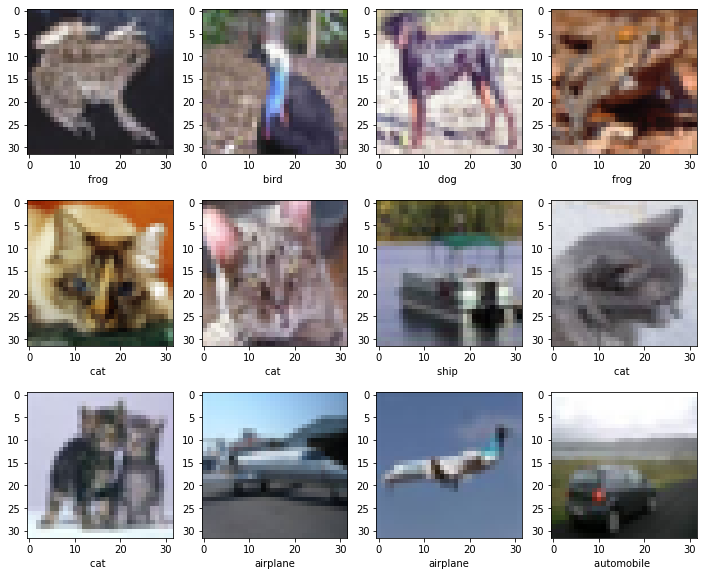

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

Нормировка:

In [9]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [10]:
model = keras.models.Sequential()

model.add(L.InputLayer(input_shape=[32,32,3]))
model.add(L.Flatten())
model.add(L.Dense(300, activation='relu'))
model.add(L.Dense(100, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [11]:
model.fit(X_train, y_train, epochs=7, validation_data=[X_val, y_val])

Train on 40000 samples, validate on 10000 samples
Epoch 1/7
40000/40000 [==============================] - 28s 710us/step - loss: 1.9017 - val_loss: 1.7611
Epoch 2/7
40000/40000 [==============================] - 30s 760us/step - loss: 1.7115 - val_loss: 1.6972
Epoch 3/7
40000/40000 [==============================] - 28s 689us/step - loss: 1.6289 - val_loss: 1.6061
Epoch 4/7
40000/40000 [==============================] - 23s 579us/step - loss: 1.5752 - val_loss: 1.6270
Epoch 5/7
40000/40000 [==============================] - 28s 697us/step - loss: 1.5339 - val_loss: 1.5352
Epoch 6/7
40000/40000 [==============================] - 26s 655us/step - loss: 1.5074 - val_loss: 1.5441
Epoch 7/7
40000/40000 [==============================] - 24s 599us/step - loss: 1.4837 - val_loss: 1.5742


In [12]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.4451


AssertionError: Not good enough. Back to the drawing board :)

### Улучшаем модель
Составьте и обучите модель, состоящую из следующих слоёв:

- Входной слой
- Свёртка 3x3 с 10 фильтрами
- Нелинейность на ваш вкус
- Max-pooling 2x2
- Вытягиваем оставшееся в вектор (Flatten)
- Полносвязный слой на 100 нейронов
- Нелинейность на ваш вкус
- Выходной полносвязный слой с softmax

In [ ]:
model = keras.models.Sequential()

model.add(L.InputLayer(input_shape=[32,32,3]))
model.add(L.Conv2D(filters=10, kernel_size=(3,3)))
model.add(L.Activation('relu'))
model.add(L.MaxPooling2D())
model.add(L.Flatten())
model.add(L.Dense(100, activation='relu'))
model.add(L.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=5, validation_data=[X_val, y_val])

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

# Распознавание штрихкодов

In [19]:
def viewImage(image):
    cv2.namedWindow('Display', cv2.WINDOW_NORMAL)
    cv2.imshow('Display', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [20]:
image='s1.jpg'
# load the image and convert it to grayscale
image = cv2.imread(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction
gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
 
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)
viewImage(gradient)

In [21]:
# blur and threshold the image
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
viewImage(thresh)

Мы начнем с создания прямоугольника с помощью cv2.getStructuringElement. Ширина ядра больше его высоты, что позволяет нам перекрыть пространство между вертикальными полосками штрихкода.

Далее, произведем нашу морфологическую операцию, применив ядро к бинаризированному изображению, замазывая пространство между полосками. И вы можете сами увидеть, что «пробелы» почти полностью закрыты, по сравнению с изображениями выше:

In [22]:
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
viewImage(closed)

Избавляемся от артифактов

In [23]:
# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations = 4)
viewImage(closed)

Ищем контуры штрихкода: cv2.RETR_EXTERNAL

In [27]:
# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
(_,cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
 
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))
 
# draw a bounding box arounded the detected barcode and display the
# image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
viewImage(image)

# Предобработка

https://habr.com/ru/post/341160/

In [5]:
from __future__ import print_function
import glob
import common
import os
import cv2

Для поиска поправки выполняем:

In [11]:
img_name = 'ex1.png'

square_size = 1.0

pattern_size = (9, 6)
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = 0, 0
img_names_undistort = []

img = cv2.imread(img_name, 0)


h, w = img.shape[:2]
found, corners = cv2.findChessboardCorners(img, pattern_size)

term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

img_points.append(corners.reshape(-1, 2))
obj_points.append(pattern_points)

print('ok')

rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

cv2.destroyAllWindows()

ok

RMS: 0.17250100667938964
camera matrix:
 [[534.57403843   0.         373.72147751]
 [  0.         515.66878838 304.07240545]
 [  0.           0.           1.        ]]
distortion coefficients:  [-0.35439868  0.09507107 -0.01655048  0.00073706  0.0178794 ]


In [12]:
img_name = 'ex1.png'

print(img_name)

camera_matrix = camera_matrix
dist_coefs = dist_coefs
#for img_found in img_names_undistort:

img = cv2.imread(img_name)
    
viewImage(img)
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))

dst = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

viewImage(dst)
    
# crop and save the image
x, y, w, h = roi
dst = dst[y:y+h-50, x+70:x+w-20]
    
viewImage(dst)


full_name = 'new.jpg'

#outfile = img_names_undistort + '_undistorte.png'
print('Undistorted image written to: %s' % full_name)
cv2.imwrite(full_name, dst)

ex1.png
Undistorted image written to: new.jpg


True

# Сегментация изображений

In [1]:
import cv2
import numpy as np

Разделим изображение на 17 колец по уровням серого, а затем измерим площадь каждого кольца, ограниченного контуром.

In [2]:
def grayscale_17_levels (image):
    high = 255
    while(1): 
        low = high-15
        col_to_be_changed_low = np.array([low])
        col_to_be_changed_high = np.array([high])
        curr_mask = cv2.inRange(gray, col_to_be_changed_low,col_to_be_changed_high)
        gray[curr_mask > 0] = (high)
        high -= 15
        if(low == 0 ):
            break
image = cv2.imread('o.png')
viewImage(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grayscale_17_levels(gray)
viewImage(gray)

In [3]:
def get_area_of_each_gray_level(im):
    ## convert image to gray scale (must br done before contouring)
    image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    output = []
    high = 255
    first = True
    while (1):

        low = high - 15
        if (first == False):
            ## making values that are of a greater gray level black
            ## so it won't get detected
            to_be_black_again_low = np.array([high])
            to_be_black_again_high = np.array([255])
            curr_mask = cv2.inRange(image, to_be_black_again_low,
                                    to_be_black_again_high)
            image[curr_mask > 0] = (0)

        # making values of this gray level white so we can calculate
        # it's area
        ret, threshold = cv2.threshold(image, low, 255, 0)
        h, contours, hirerchy = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        if (len(contours) > 0):
            output.append([cv2.contourArea(contours[0])])
            cv2.drawContours(im, contours, -1, (0, 0, 255), 3)
            

        high -= 15
        first = False
        if (low == 0):
            break
    return output

Получаются площади:

In [4]:
image = cv2.imread('o.png')
print(get_area_of_each_gray_level(image))
viewImage(image)

[[5871.0], [6480.0], [13012.0], [21820.0], [32902.0], [46238.0], [61761.0], [79709.0], [99787.0], [122222.0], [146859.0], [173758.0], [202919.5], [234401.5], [12241.5], [11577.0], [11111.0]]


### Обнаружение объекта

In [7]:
image = cv2.imread('l1.jpeg')
viewImage(image)

In [8]:
# Convert BGR to HSV
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
viewImage(hsv_img) 

In [9]:
green_low = np.array([45 , 100, 50] )
green_high = np.array([75, 255, 255])
curr_mask = cv2.inRange(hsv_img, green_low, green_high)
hsv_img[curr_mask > 0] = ([75,255,200])
viewImage(hsv_img) ## 2

In [10]:
## converting the HSV image to Gray inorder to be able to apply 
## contouring
RGB_again = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
gray = cv2.cvtColor(RGB_again, cv2.COLOR_RGB2GRAY)
viewImage(gray) ## 3

In [11]:
ret, threshold = cv2.threshold(gray, 90, 255, 0)
viewImage(threshold) ## 4

In [12]:
h, contours, hierarchy =  cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (0, 0, 255), 3)
viewImage(image) ## 5